Pseudo-randomly selected digits: [1, 3, 5, 7]
Number of iterations: 5000
Avg. (normalized) dist. between successive center coordinates: 1.847175416061103e-05


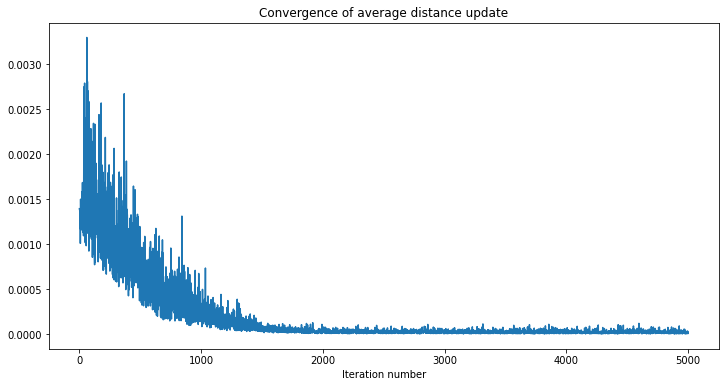

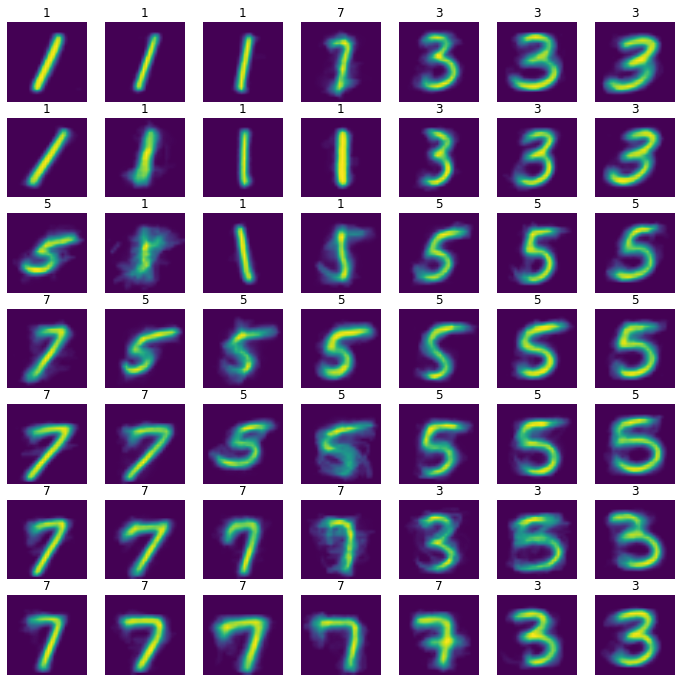

In [ ]:

import numpy as np
import matplotlib.pylab as plb


def name2digits(name, hash_path='data/hash.mat'):
   
    name = name.lower()
    n = len(name)
    if n > 25:
        name = name[0:25]

    prime_numbers = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47,
                     53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

    seed = 0.0
    for i in range(n):
        seed += prime_numbers[i] * ord(name[i]) * 2.0**(i + 1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('data/hash.mat', struct_as_record=True)
    digits_choices = Data['x']
    n_choices = digits_choices.shape[0]

    row = np.mod(seed, n_choices).astype('int')

    digits = np.sort(digits_choices[row, :])
    return digits


def preprocess_mnist(data_path='data/data.txt', label_path='data/labels.txt',
                     hash_path='data/hash.mat', name='Saucedo',
                     non_randomic_digits=None):


    data = np.array(np.loadtxt(data_path))
    labels = np.loadtxt(label_path)
    hash_path = np

    if non_randomic_digits is None:
      digits = name2digits(name, hash_path=hash_path)
    else:
      digits = non_randomic_digits

    rows_mask = np.logical_or.reduce([labels == x for x in digits])
    data = data[rows_mask, :]
    labels = labels[rows_mask].astype('int')

    return data, digits, labels


def gauss(x, p):
    
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))


def neighborhood_decrease_rate(sigma_ini, sigma_fin, nit, maxit):
    return sigma_ini * (sigma_fin / sigma_ini) ** (nit / maxit)


def som_step(centers, datapoint, neighbor_matrix, eta, sigma):

    # Initialization
    n_centers, dim = centers.shape

    # Find the best matching unit (bmu)
    error = np.sum((centers - datapoint) ** 2, axis=1)
    bmu = np.argmin(error)

    # Find coordinates of the bmu on the map
    a_bmu, b_bmu = np.nonzero(neighbor_matrix == bmu)

    # Update all units
    for j in range(n_centers):
        # Find coordinates of the current unit
        a, b = np.nonzero(neighbor_matrix == j)

        # Calculate the discounting factor of the neighborhood function
        dist = np.sqrt((a_bmu - a)**2 + (b_bmu - b)**2)
        disc = gauss(dist, [0, sigma])

        # update weights
        centers[j, :] += disc * eta * (datapoint - centers[j, :])

    return error


def kohonen(data, size_k=6, sigma=2.0, eta=0.9, maxit=5000, tol=0, verbose=0,
            sigma_fun=None):


    n_samples, dim = data.shape
    data_range = np.max(data)
    n_centers = int(size_k ** 2)
    centers = np.random.rand(n_centers, dim) * data_range
    neighbor_matrix = np.arange(n_centers).reshape((size_k, size_k))
    sigma_ini = sigma
    sigma_fin = 0.01
    avg_dist = np.zeros((maxit,))

    order = np.arange(maxit) % n_samples
    np.random.shuffle(order)


    centers_old = np.copy(centers)
    nit = 0
    for i in order:
        if sigma_fun is not None:
            sigma = sigma_fun(sigma_ini, sigma_fin, nit, maxit)

        som_step(centers, data[i, :], neighbor_matrix, eta, sigma)

        nit += 1

        dist = np.sum((centers - centers_old) ** 2, axis=1) / \
            np.sum(centers_old ** 2, axis=1)

        avg_dist[nit - 1] = np.mean(dist)
        if avg_dist[nit - 1] <= tol:
            avg_dist = avg_dist[:(nit - 1)]
            print("Tolerancia, i = {}".format(nit - 1))
            break

        centers_old[:] = centers

    if verbose > 0:
        print('Numero de interações:', nit)
        print('Média:',
              avg_dist[-1])
        plb.figure(figsize=(12, 6))
        plb.plot(list(range(1, len(avg_dist) + 1)), avg_dist)
        plb.title('Convergencia')
        plb.xlabel('Interação')
        plb.show()

    return centers


def visualize_map(centers, data=None, labels=None):
  

    size_k = int(np.sqrt(centers.shape[0]))
    dim = int(np.sqrt(centers.shape[1]))


    plb.figure(figsize=(12, 12))

    for i in range(centers.shape[0]):

        plb.subplot(size_k, size_k, i + 1)

        plb.imshow(np.reshape(centers[i, :], [dim, dim]),
                   interpolation='bilinear')

        if (data is not None) and (labels is not None):
            dist = np.sum((centers[i, :] - data) ** 2, axis=1)
            row_match = np.argmin(dist)
            plb.title(labels[row_match])

        plb.axis('off')

    plb.show()


if __name__ == "__main__":


    data_path = 'data/data.txt'
    label_path = 'data/labels.txt'
    hash_path = 'data/hash.mat'
    name = 'Saucedo'

    data, digits, labels = preprocess_mnist(data_path, label_path, hash_path,
                                            name, [1, 3, 5, 7])
    print('digits:', digits)

    size_k = 7
    sigma = 5
    eta = 0.05
    maxit = 5000
    tol = 1e-6

    centers = kohonen(data, size_k, sigma, eta, maxit, tol, verbose=1,
                      sigma_fun=neighborhood_decrease_rate)

    visualize_map(centers, data, labels)
